In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data

import torch.optim as optim

import torchvision
from torchvision import datasets as dsets
from torchvision import transforms

import torchvision.models.resnet as resnet

from matplotlib.pyplot import imshow
%matplotlib inline

import visdom
import math
import vgg
import numpy as np

In [2]:
vis = visdom.Visdom()
vis.close(env="main")

''

In [3]:
def plt_tracker(loss_plot, loss_value, num):
    vis.line(X=np.stack(np.arange(num, num+1)),
             Y=np.stack([loss_value]),
             win=loss_plot,
             update='append'
             )

In [4]:
if (torch.cuda.is_available() == 1):
    print("cuda is available")
    device = 'cuda'
else:
    device = 'cpu'

cuda is available


In [5]:
transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomCrop(56),
    transforms.ToTensor(),]
    #transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))]
)

Dataset is alreay downlaoded
Dataset ImageFolder
    Number of datapoints: 100000
    Root Location: ./tiny-imagenet-200/train
    Transforms (if any): Compose(
                             RandomCrop(size=(56, 56), padding=0)
                             ToTensor()
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 10000
    Root Location: ./tiny-imagenet-200/val
    Transforms (if any): Compose(
                             RandomCrop(size=(56, 56), padding=0)
                             ToTensor()
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 10000
    Root Location: ./tiny-imagenet-200/test
    Transforms (if any): Compose(
                             RandomCrop(size=(56, 56), padding=0)
                             ToTensor()
                         )
    Target Transforms (if any): None
<PIL.Image.Image image mode=RGB size=56x56 at 0x7FD0A6254400>


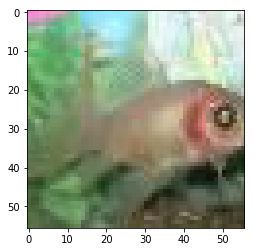

In [7]:
try:
    train = dsets.ImageFolder(root='./tiny-imagenet-200/train',transform=transform)
    print("Dataset is alreay downlaoded")
except:
    !./download.sh
    train = dsets.ImageFolder(root='./tiny-imagenet-200/train',transform=transform)
    
        
validation = dsets.ImageFolder(root='./tiny-imagenet-200/val',transform=transform)
test = dsets.ImageFolder(root='./tiny-imagenet-200/test',transform=transform)

print(train)
print(validation)
print(test)


check_img=train.__getitem__(0)
ToPIL=transforms.ToPILImage()
check_img = ToPIL(check_img[0])
print(check_img)

imshow(check_img)

In [8]:
train_loader=data.DataLoader(train, batch_size=256, shuffle=True, num_workers=2)
var_loader=data.DataLoader(validation, batch_size=64, shuffle=False, num_workers=2)
test_loader=data.DataLoader(test, batch_size=64, shuffle=False, num_workers=2)

In [9]:
BasicBlock = resnet.BasicBlock
Bottleneck = resnet.Bottleneck

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [10]:
CNN = ResNet(BasicBlock, [2,2,2,2])
CNN=CNN.to(device)
#print(CNN)

In [11]:
test_input = torch.Tensor(3,3,56,56).to(device)

out = CNN(test_input)
print(out.shape)

torch.Size([3, 1000])


In [12]:
optimizer = optim.SGD(CNN.parameters(),lr=0.01,momentum=0.9)

loss_function = nn.CrossEntropyLoss()

lr_sche = optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.8)

In [13]:
loss_plot = vis.line(Y=torch.Tensor(1).zero_())

In [14]:
epochs = 30
print("length of train_loader : {}".format(len(train_loader)))
for epoch in range(epochs):
    running_loss = 0.0
    check_loss = 0.0
    lr_sche.step()
    for num, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = CNN(inputs) xcv
        loss = loss_function(out, labels)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        check_loss += loss.item()
        
        if (num % 30 == 1) and (num != 1):
            check_loss = check_loss/30
            print("loss : {}".format(check_loss))
            plt_tracker(loss_plot,(check_loss), epoch *len(train_loader) + num)
            check_loss = 0  
        
        if num % len(train_loader) == (len(train_loader) - 1):
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, num + 1, running_loss / len(train_loader)))
            running_loss = 0.0
            check_loss = 0.0

length of train_loader : 391


loss : 6.592318518956502


loss : 5.274655278523763


loss : 5.051894124348959


loss : 4.929690186182658


loss : 4.822161022822062


loss : 4.720848862330119


loss : 4.669668054580688


loss : 4.582826105753581


loss : 4.5109468460083


loss : 4.459316349029541


loss : 4.367632675170898


loss : 4.32915194829305


[1,   391] loss: 4.791


loss : 4.486920022964478


loss : 4.146384231249491


loss : 4.088078037897746


loss : 4.077641558647156


loss : 4.013285152117411


loss : 4.033398826917012


loss : 3.9306655804316204


loss : 3.9070751825968424


loss : 3.9108022689819335


loss : 3.8464709758758544


loss : 3.8284517844518025


loss : 3.792956821123759


[2,   391] loss: 3.967


loss : 3.9523473342259723


loss : 3.621480441093445


loss : 3.6162669897079467


loss : 3.5952698230743407


loss : 3.59522758324941


loss : 3.530564554532369


loss : 3.5292307138442993


loss : 3.5481555620829264


loss : 3.506607977549235


loss : 3.4574460347493488


loss : 3.479162875811259


loss : 3.4489148457845054


[3,   391] loss: 3.546


loss : 3.58801748752594


loss : 3.359804940223694


loss : 3.3294700145721436


loss : 3.351533579826355


loss : 3.338917032877604


loss : 3.311070426305135


loss : 3.2773622194925944


loss : 3.2208446502685546


loss : 3.2318428913752237


loss : 3.2561893383661906


loss : 3.2680216391881305


loss : 3.2437570015589396


[4,   391] loss: 3.291


loss : 3.324931756655375


loss : 3.069119413693746


loss : 3.080585789680481


loss : 3.098533296585083


loss : 3.0632854143778485


loss : 3.0748444477717083


loss : 3.0456221103668213


loss : 3.106425412495931


loss : 3.0545000076293944


loss : 3.0367810567220053


loss : 3.0343169371287027


loss : 3.0289223829905194


[5,   391] loss: 3.063


loss : 3.1056010007858275


loss : 2.961023203531901


loss : 2.910249447822571


loss : 2.901003591219584


loss : 2.9429215669631956


loss : 2.9316588322321575


loss : 2.922925821940104


loss : 2.909501584370931


loss : 2.9314300855000814


loss : 2.8881507396697996


loss : 2.886162765820821


loss : 2.880518364906311


[6,   391] loss: 2.913


loss : 2.989755050341288


loss : 2.747197922070821


loss : 2.7636650641759237


loss : 2.759817894299825


loss : 2.7720431725184125


loss : 2.7829933484395344


loss : 2.742639700571696


loss : 2.777174711227417


loss : 2.74596053759257


loss : 2.7479561805725097


loss : 2.734261703491211


loss : 2.7111406723658242


[7,   391] loss: 2.756


loss : 2.887129282951355


loss : 2.656375026702881


loss : 2.6262900988260904


loss : 2.65154234568278


loss : 2.651560155550639


loss : 2.6646892786026


loss : 2.6602215210596722


loss : 2.6688990036646527


loss : 2.6057313839594523


loss : 2.64038405418396


loss : 2.6438576380411782


loss : 2.639670753479004


[8,   391] loss: 2.650


loss : 2.6987488587697346


loss : 2.5401338736216226


loss : 2.575506027539571


loss : 2.53844469388326


loss : 2.5292744795481363


loss : 2.4766643762588503


loss : 2.5356077353159585


loss : 2.523900532722473


loss : 2.521003492673238


loss : 2.510040211677551


loss : 2.5122507015864053


loss : 2.540691844622294


[9,   391] loss: 2.528


loss : 2.60193456808726


loss : 2.45979589621226


loss : 2.454818606376648


loss : 2.4538519461949666


loss : 2.447377347946167


loss : 2.425889738400777


loss : 2.485127258300781


loss : 2.4433433135350544


loss : 2.4801769812901813


loss : 2.4470521529515583


loss : 2.448457153638204


loss : 2.4733360528945925


[10,   391] loss: 2.453


loss : 2.5078048706054688


loss : 2.3471681753794353


loss : 2.40178013642629


loss : 2.3300474961598714


loss : 2.3388434410095216


loss : 2.3522454420725505


loss : 2.3460041602452595


loss : 2.3705750465393067


loss : 2.379241704940796


loss : 2.3376266876856486


loss : 2.381720606486003


loss : 2.376473871866862


[11,   391] loss: 2.358


loss : 2.431045905749003


loss : 2.29599293867747


loss : 2.2998348792394


loss : 2.3087969462076825


loss : 2.2687682708104453


loss : 2.3011674006779987


loss : 2.2982858339945476


loss : 2.302388374010722


loss : 2.3256489117940267


loss : 2.290472388267517


loss : 2.310495686531067


loss : 2.306771818796794


[12,   391] loss: 2.299


loss : 2.3630930264790853


loss : 2.260788643360138


loss : 2.2500078598658244


loss : 2.1849677165349326


loss : 2.2429075042406716


loss : 2.1994449694951377


loss : 2.2279972632726035


loss : 2.1949501752853395


loss : 2.2363138675689695


loss : 2.2063868363698322


loss : 2.195293708642324


loss : 2.2078377048174542


[13,   391] loss: 2.220


loss : 2.2750773350397746


loss : 2.170145301024119


loss : 2.1818746527036033


loss : 2.170322283109029


loss : 2.1620555758476256


loss : 2.163740662733714


loss : 2.208055313428243


loss : 2.1555877049763996


loss : 2.1654252886772154


loss : 2.184775427977244


loss : 2.1609229882558187


loss : 2.185124897956848


[14,   391] loss: 2.172


loss : 2.2296648462613424


loss : 2.1043548504511516


loss : 2.0982765197753905


loss : 2.1253750681877137


loss : 2.1164549350738526


loss : 2.115951577822367


loss : 2.1193369468053183


loss : 2.0842955072720843


loss : 2.1308701157569887


loss : 2.120504319667816


loss : 2.0962510267893473


loss : 2.0701833089192707


[15,   391] loss: 2.107


loss : 2.2096179525057473


loss : 2.053609013557434


loss : 2.091622734069824


loss : 2.041564170519511


loss : 2.0633294343948365


loss : 2.079878735542297


loss : 2.046446708838145


loss : 2.0772876103719073


loss : 2.085689640045166


loss : 2.060795255502065


loss : 2.0863096912701926


loss : 2.0727816939353945


[16,   391] loss: 2.071


loss : 2.120145551363627


loss : 2.0290871183077495


loss : 2.004543300469716


loss : 2.0238588492075604


loss : 1.9618961413701375


loss : 1.9798901279767354


loss : 2.0412991046905518


loss : 2.0161121328671774


loss : 2.0349724769592283


loss : 2.031216367085775


loss : 2.028363875548045


loss : 2.015015693505605


[17,   391] loss: 2.013


loss : 2.1007556239763896


loss : 1.9275397857030232


loss : 1.9885860959688821


loss : 1.9373803337415059


loss : 1.973659666379293


loss : 1.9823845068613688


loss : 1.9819089810053507


loss : 1.9782657663027445


loss : 1.979968822002411


loss : 1.9820905049641928


loss : 2.0301799019177755


loss : 1.9921881079673767


[18,   391] loss: 1.981


loss : 2.045079779624939


loss : 1.9224854469299317


loss : 1.9174688617388407


loss : 1.9367192109425864


loss : 1.9022829373677572


loss : 1.8898558378219605


loss : 1.9550858894983927


loss : 1.9575369079907736


loss : 1.9610082149505614


loss : 1.9392322500546773


loss : 1.953632613023122


loss : 1.9396322091420493


[19,   391] loss: 1.934


loss : 2.0091146151224772


loss : 1.902357534567515


loss : 1.9367433627446493


loss : 1.9256969292958577


loss : 1.8976842840512593


loss : 1.9251628875732423


loss : 1.9128776987393696


loss : 1.8913081447283426


loss : 1.9168965657552084


loss : 1.8982317288716635


loss : 1.8812679370244345


loss : 1.916588032245636


[20,   391] loss: 1.907


loss : 1.972208042939504


loss : 1.835082479317983


loss : 1.8834969043731689


loss : 1.8447318196296691


loss : 1.8741495172182718


loss : 1.8886435310045877


loss : 1.876702638467153


loss : 1.8682604908943177


loss : 1.881817634900411


loss : 1.8740092158317565


loss : 1.8672814647356668


loss : 1.879674780368805


[21,   391] loss: 1.866


loss : 1.969767149289449


loss : 1.82571994860967


loss : 1.8514293034871419


loss : 1.822290825843811


loss : 1.8310328483581544


loss : 1.8126997351646423


loss : 1.8415841658910115


loss : 1.8582655310630798


loss : 1.83540833791097


loss : 1.8687989274660746


loss : 1.8675022363662719


loss : 1.8832515120506286


[22,   391] loss: 1.847


loss : 1.90560302734375


loss : 1.7872134923934937


loss : 1.8064956029256185


loss : 1.81026664574941


loss : 1.841449991861979


loss : 1.8137056827545166


loss : 1.8349771539370219


loss : 1.812428609530131


loss : 1.8273985664049783


loss : 1.7957235376040142


loss : 1.8289599180221559


loss : 1.8215654810269675


[23,   391] loss: 1.811


loss : 1.87623526652654


loss : 1.7791652083396912


loss : 1.7737744609514872


loss : 1.7786142508188882


loss : 1.797151267528534


loss : 1.8172281861305237


loss : 1.8022032419840495


loss : 1.7803534746170044


loss : 1.84030392964681


loss : 1.7881245533625285


loss : 1.8314661105473837


loss : 1.7862099488576253


[24,   391] loss: 1.795


loss : 1.8634044726689656


loss : 1.7673594117164613


loss : 1.7431358337402343


loss : 1.7743133823076884


loss : 1.7658441662788391


loss : 1.7697288990020752


loss : 1.7714290698369344


loss : 1.77781746784846


loss : 1.7692894379297892


loss : 1.7822949250539144


loss : 1.8089739322662353


loss : 1.7588889877001443


[25,   391] loss: 1.771


loss : 1.8492425243059794


loss : 1.7322447180747986


loss : 1.7552294532457988


loss : 1.7104413112004597


loss : 1.7577661156654358


loss : 1.792443044980367


loss : 1.7739106694857278


loss : 1.7367077827453614


loss : 1.7412975311279297


loss : 1.7752274076143901


loss : 1.7687059879302978


loss : 1.7643812417984008


[26,   391] loss: 1.755


loss : 1.8642027338345846


loss : 1.7193291107813518


loss : 1.7307703177134195


loss : 1.7054709513982138


loss : 1.7152826031049093


loss : 1.7135693828264873


loss : 1.7211949944496154


loss : 1.7323031266530355


loss : 1.7455625176429748


loss : 1.722814647356669


loss : 1.7357328335444133


loss : 1.7471712748209636


[27,   391] loss: 1.730


loss : 1.8102755864461264


loss : 1.7160795370737711


loss : 1.7197003761927288


loss : 1.7214035987854004


loss : 1.7445318619410197


loss : 1.7047122836112976


loss : 1.6960821549097698


loss : 1.677034072081248


loss : 1.7498609145482382


loss : 1.7460041562716166


loss : 1.747983984152476


loss : 1.7078353643417359


[28,   391] loss: 1.717


loss : 1.7936272978782655


loss : 1.6796301364898683


loss : 1.702922256787618


loss : 1.6920920332272849


loss : 1.7189761360486349


loss : 1.6566552877426148


loss : 1.6890671690305075


loss : 1.6901367425918579


loss : 1.7047842542330425


loss : 1.7172684073448181


loss : 1.7225878516832986


loss : 1.714366066455841


[29,   391] loss: 1.697


loss : 1.770674188931783


loss : 1.6727958043416342


loss : 1.6927429636319478


loss : 1.7049196163813274


loss : 1.6650567690531413


loss : 1.687883162498474


loss : 1.6879944245020548


loss : 1.6822089473406474


loss : 1.6997911095619203


loss : 1.6909730712572733


loss : 1.700060506661733


loss : 1.6854109247525533


[30,   391] loss: 1.687


In [16]:
torch.save(CNN.state_dict(),"./model/tiny_imagenet_resnet.pth")

In [17]:
load_CNN = ResNet(BasicBlock, [2,2,2,2])
load_CNN=CNN.to(device)

In [18]:
load_CNN.load_state_dict(torch.load('./model/tiny_imagenet_resnet.pth',map_location = device))
load_CNN = load_CNN.to(device)

In [24]:
print(load_CNN.conv1.weight[0][0])


tensor([[ 0.0082,  0.0583,  0.0463,  0.0789,  0.0625, -0.0065,  0.0248],
        [ 0.0088,  0.0326,  0.0191,  0.0236,  0.0690, -0.0171, -0.0030],
        [ 0.0300,  0.0414,  0.0339,  0.0657, -0.0505,  0.0079,  0.0219],
        [ 0.0288, -0.0063,  0.0282, -0.0452, -0.0467,  0.0024, -0.0045],
        [ 0.0195,  0.0615,  0.0402, -0.0390, -0.0921, -0.0455, -0.0060],
        [ 0.0335,  0.0105,  0.0247,  0.0329, -0.0695, -0.0531, -0.0656],
        [-0.0029,  0.0312,  0.0279, -0.0086, -0.0504, -0.0690, -0.0929]],
       device='cuda:0', grad_fn=<SelectBackward>)


In [25]:
print(CNN.conv1.weight.data[0][0])


tensor([[ 0.0082,  0.0583,  0.0463,  0.0789,  0.0625, -0.0065,  0.0248],
        [ 0.0088,  0.0326,  0.0191,  0.0236,  0.0690, -0.0171, -0.0030],
        [ 0.0300,  0.0414,  0.0339,  0.0657, -0.0505,  0.0079,  0.0219],
        [ 0.0288, -0.0063,  0.0282, -0.0452, -0.0467,  0.0024, -0.0045],
        [ 0.0195,  0.0615,  0.0402, -0.0390, -0.0921, -0.0455, -0.0060],
        [ 0.0335,  0.0105,  0.0247,  0.0329, -0.0695, -0.0531, -0.0656],
        [-0.0029,  0.0312,  0.0279, -0.0086, -0.0504, -0.0690, -0.0929]],
       device='cuda:0')


In [26]:
load_CNN == CNN

True